
## Load world ocean atlas, compute upper ocean thermal stratification


In [1]:
import xarray as xr
import numpy as np
%matplotlib inline
#import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()

datadir='./'

In [2]:
# load uv for one constituent
files = [datadir+'woa18_A5B7_t00_01.nc', datadir+'woa18_A5B7_s00_01.nc']
#
ds = xr.merge([xr.open_dataset(f, decode_cf=False) for f in files])
ds = ds.where(ds.t_an<1e2)

In [3]:
ds['dTdz'] = ds.t_an.diff('depth')/ds.depth.diff('depth')
ds['dTdz'] = ds['dTdz'].where(ds['dTdz']<1e2)

ds['dTdz_upper'] = np.abs(ds['dTdz'].where(ds.depth<500)).mean('depth')

/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


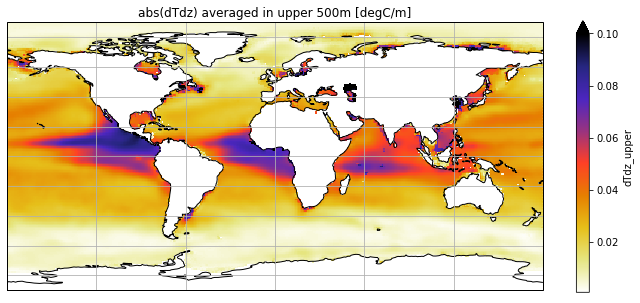

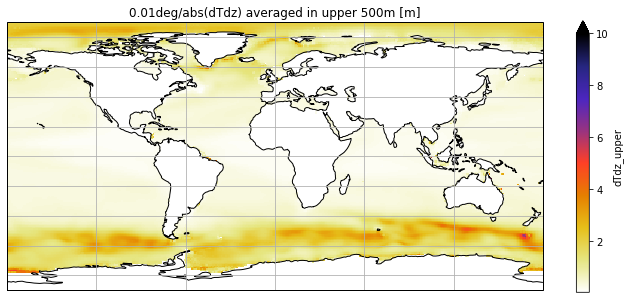

In [4]:
### plot a map of current amplitudes

plt.figure(figsize=(12, 5))
ax = plt.axes(projection=crs)
toplt = ds.dTdz_upper
hdl = toplt.plot(ax = ax, x='lon',y='lat', vmax=.1, \
                 transform = crs,cmap=plt.get_cmap('CMRmap_r'))
ax.coastlines(resolution='110m')
ax.gridlines()
ax.set_title('abs(dTdz) averaged in upper 500m [degC/m]')
plt.show()


plt.figure(figsize=(12, 5))
ax = plt.axes(projection=crs)
toplt = 0.01/ds.dTdz_upper
hdl = toplt.plot(ax = ax, x='lon', y='lat', vmax=10.,\
                 transform = crs,cmap=plt.get_cmap('CMRmap_r'))
ax.coastlines(resolution='110m')
ax.gridlines()
ax.set_title('0.01deg/abs(dTdz) averaged in upper 500m [m]')
plt.show()

/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0, 0.5, '[m]')

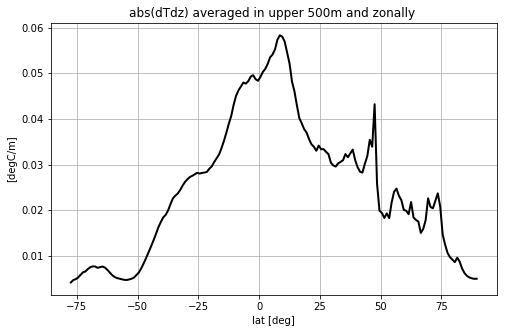

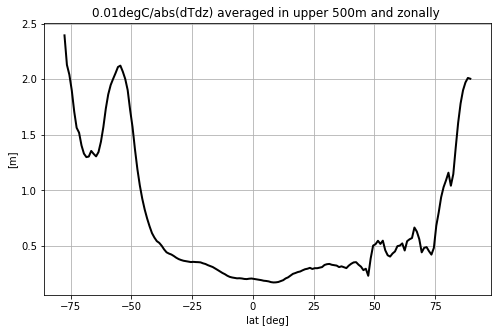

In [5]:
### same but averaged zonally

plt.figure(figsize=(8.,5.))
ax = plt.gca()
ds.dTdz_upper.mean('lon').plot(ax = ax, color='k', lw=2.)
#ax.plot(lat,dTdz_upper.mean('lon'),)
ax.grid()
ax.set_title('abs(dTdz) averaged in upper 500m and zonally ')
ax.set_xlabel('lat [deg]')
ax.set_ylabel('[degC/m]')


plt.figure(figsize=(8.,5.))
ax = plt.gca()
#ax.plot(lat,(.01/dTdz_upper).mean('lon'),'k',lw=2.)
(.01/ds.dTdz_upper.mean('lon')).plot(ax = ax, color='k',lw=2.)
ax.grid()
ax.set_title('0.01degC/abs(dTdz) averaged in upper 500m and zonally ')
ax.set_xlabel('lat [deg]')
ax.set_ylabel('[m]')



---

## in situ density stratification

impact for volume displacement: $V_0 \delta \rho/\rho - V_0 (\gamma 500m - alpha dT ) $

In [6]:
import gsw

In [7]:
temp, s, depth, lon, lat = xr.broadcast(ds.t_an.squeeze(), ds.s_an.squeeze(), ds.depth, ds.lon, ds.lat)
p = gsw.p_from_z(-depth, lat)

In [9]:
SA = gsw.SA_from_SP(s, p, lon, lat)
CT = gsw.CT_from_t(SA, temp, p)
rho = gsw.density.rho(SA, CT, p)

In [10]:
ds['rho'] = xr.DataArray(rho, dims=temp.dims)

Text(0.5, 1.0, 'rho(500m) - rho(0m)')

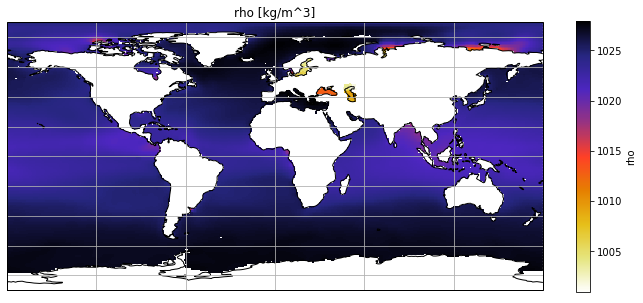

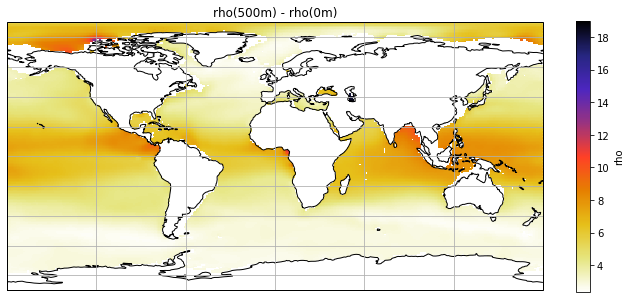

In [19]:
### plot a map of current amplitudes

plt.figure(figsize=(12, 5))
ax = plt.axes(projection=crs)
toplt = ds.rho.sel(depth=0., method='nearest')
hdl = toplt.plot(ax = ax, x='lon',y='lat', vmax=None, \
                 transform = crs,cmap=plt.get_cmap('CMRmap_r'))
ax.coastlines(resolution='110m')
ax.gridlines()
ax.set_title('rho [kg/m^3]')

plt.figure(figsize=(12, 5))
ax = plt.axes(projection=crs)
toplt = ds.rho.sel(depth=500., method='nearest') - ds.rho.sel(depth=0., method='nearest')
hdl = toplt.plot(ax = ax, x='lon', y='lat', vmax=None,\
                 transform = crs,cmap=plt.get_cmap('CMRmap_r'))
ax.coastlines(resolution='110m')
ax.gridlines()
ax.set_title('rho(500m) - rho(0m)')

In [32]:
# float parameters
V0 = 1.24e4   # cm^3 Ifremer prototype volume
gamma = 3.5e-6  # /dbar, CR values
alpha = 6.9e-5  # /degC, CR values
depth = 500 # m

Text(0.5, 1.0, 'V0[rho(500m) - rho(0m)]/rho max = 233.9 cm^3')

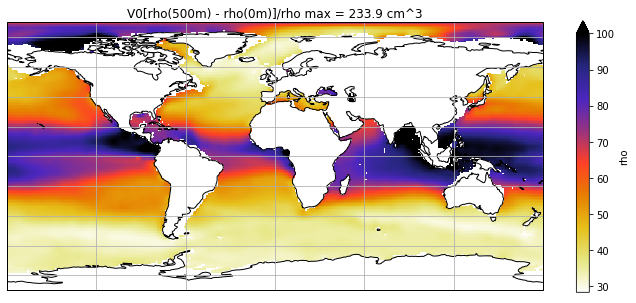

In [47]:
dv_rho = V0*(ds.rho.sel(depth=depth, method='nearest') - ds.rho.sel(depth=0., method='nearest')) \
            /ds.rho.sel(depth=0., method='nearest')

plt.figure(figsize=(12, 5))
ax = plt.axes(projection=crs)
toplt = dv_rho
hdl = toplt.plot(ax = ax, x='lon', y='lat', vmax=100,\
                 transform = crs,cmap=plt.get_cmap('CMRmap_r'))
ax.coastlines(resolution='110m')
ax.gridlines()
ax.set_title('V0[rho(%dm) - rho(0m)]/rho max = %.1f cm^3' %(depth,toplt.max()))

In [42]:
dv_p = V0*gamma*depth
print('change of volume du to compressibility = %.1f cm^3'%dv_p)

change of volume du to compressibility = 21.7 cm^3


Text(0.5, 1.0, 'dv_T max = 19.5 cm^3')

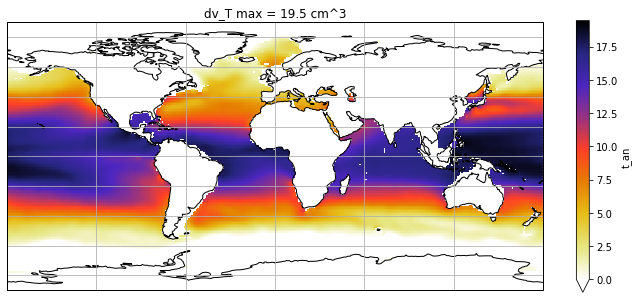

In [51]:
dv_T = -V0*alpha*(ds.t_an.sel(depth=500., method='nearest') - ds.t_an.sel(depth=0., method='nearest'))

plt.figure(figsize=(12, 5))
ax = plt.axes(projection=crs)
toplt = dv_T
hdl = toplt.plot(ax = ax, x='lon', y='lat', vmin=0., vmax=None,\
                 transform = crs,cmap=plt.get_cmap('CMRmap_r'))
ax.coastlines(resolution='110m')
ax.gridlines()
ax.set_title('dv_T max = %.1f cm^3' %toplt.max())

Text(0.5, 1.0, 'dv max = 200.5 cm^3')

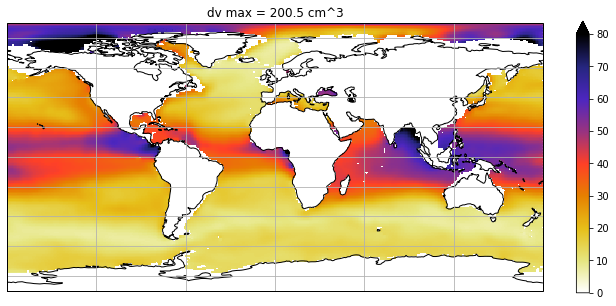

In [50]:
dv = dv_rho - dv_p - dv_T

plt.figure(figsize=(12, 5))
ax = plt.axes(projection=crs)
toplt = dv
hdl = toplt.plot(ax = ax, x='lon', y='lat', vmin=0., vmax=80,\
                 transform = crs,cmap=plt.get_cmap('CMRmap_r'))
ax.coastlines(resolution='110m')
ax.gridlines()
ax.set_title('dv max = %.1f cm^3' %toplt.max())